## 1. Setup and Data Loading

In [42]:
import pandas as pd
import numpy as np

import os
import re
from collections import Counter
from wordcloud import WordCloud

In [43]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from empath import Empath

import spacy
import gensim
from gensim.corpora import Dictionary
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to C:\Users\Parth
[nltk_data]     Hanchate\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to C:\Users\Parth
[nltk_data]     Hanchate\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Parth
[nltk_data]     Hanchate\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Parth
[nltk_data]     Hanchate\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
PLOT_DIRECTORY = 'visualizations'
if not os.path.exists(PLOT_DIRECTORY):
    os.makedirs(PLOT_DIRECTORY)

In [68]:
nlp = spacy.load('en_core_web_sm')

In [69]:
PATH = os.path.join(os.getcwd(), 'data', 'RMHD_Sampled.csv')
df = pd.read_csv(PATH)

In [70]:
df.head()

,author,score,subreddit,timestamp,title,text,year_month
0,quietcranberry,2,Anxiety,2019-09-08 12:04:17,make failure tiny bit bearable,getting back exam know failed tomorrow somewha...,2019-09
1,anxietywarriorr,2,Anxiety,2019-09-20 01:51:02,promise making,upsettingtriggering event occur work tuesday e...,2019-09
2,smh_matrix,2,Anxiety,2019-09-20 05:12:43,feel like crawling fedal position returning mo...,every break cant keep fighting tired keeping h...,2019-09
3,plinkus01,1,Anxiety,2019-09-26 16:01:59,anxiety think good enough school,starting final year high school week terrible ...,2019-09
4,dsaddffddrrh,7,Anxiety,2019-09-18 22:32:12,im missing school good reason,im sick im anxious school around many people f...,2019-09


In [71]:
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (22809, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22809 entries, 0 to 22808
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   author      22809 non-null  object
 1   score       22809 non-null  int64 
 2   subreddit   22809 non-null  object
 3   timestamp   22809 non-null  object
 4   title       22570 non-null  object
 5   text        20581 non-null  object
 6   year_month  22809 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.2+ MB


## 2. Data Preprocessing and Feature Extraction

### 2.1 Basic Preprocessing

In [72]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

In [73]:
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
author            0
score             0
subreddit         0
timestamp         0
title           239
text           2228
year_month        0
year              0
month             0
day               0
day_of_week       0
hour              0
dtype: int64


In [74]:
df.dropna(inplace=True)
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
author         0
score          0
subreddit      0
timestamp      0
title          0
text           0
year_month     0
year           0
month          0
day            0
day_of_week    0
hour           0
dtype: int64


In [75]:
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['title_char_count'] = df['title'].apply(lambda x: len(str(x)))
df['text_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['text_char_count'] = df['text'].apply(lambda x: len(str(x)))
df['total_word_count'] = df['title_word_count'] + df['text_word_count']

In [76]:
df['pre_covid'] = df['timestamp'] < pd.to_datetime('2020-03-01')
df['pandemic_phase'] = pd.cut(
    df['timestamp'], 
    bins=[
        pd.to_datetime('2018-01-01'),
        pd.to_datetime('2020-03-01'),
        pd.to_datetime('2020-12-31'),
        pd.to_datetime('2021-12-31'),
        pd.to_datetime('2022-12-31')
    ],
    labels=['Pre-pandemic', 'Early pandemic', 'Mid pandemic', 'Late pandemic']
)

In [77]:
df.head()

,author,score,subreddit,timestamp,title,text,year_month,year,month,day,day_of_week,hour,title_word_count,title_char_count,text_word_count,text_char_count,total_word_count,pre_covid,pandemic_phase
0,quietcranberry,2,Anxiety,2019-09-08 12:04:17,make failure tiny bit bearable,getting back exam know failed tomorrow somewha...,2019-09,2019,9,8,6,12,5,30,26,179,31,True,Pre-pandemic
1,anxietywarriorr,2,Anxiety,2019-09-20 01:51:02,promise making,upsettingtriggering event occur work tuesday e...,2019-09,2019,9,20,4,1,2,14,37,256,39,True,Pre-pandemic
2,smh_matrix,2,Anxiety,2019-09-20 05:12:43,feel like crawling fedal position returning mo...,every break cant keep fighting tired keeping h...,2019-09,2019,9,20,4,5,8,55,36,245,44,True,Pre-pandemic
3,plinkus01,1,Anxiety,2019-09-26 16:01:59,anxiety think good enough school,starting final year high school week terrible ...,2019-09,2019,9,26,3,16,5,32,43,279,48,True,Pre-pandemic
4,dsaddffddrrh,7,Anxiety,2019-09-18 22:32:12,im missing school good reason,im sick im anxious school around many people f...,2019-09,2019,9,18,2,22,5,29,30,179,35,True,Pre-pandemic


### 2.2 Initial Data Exploration

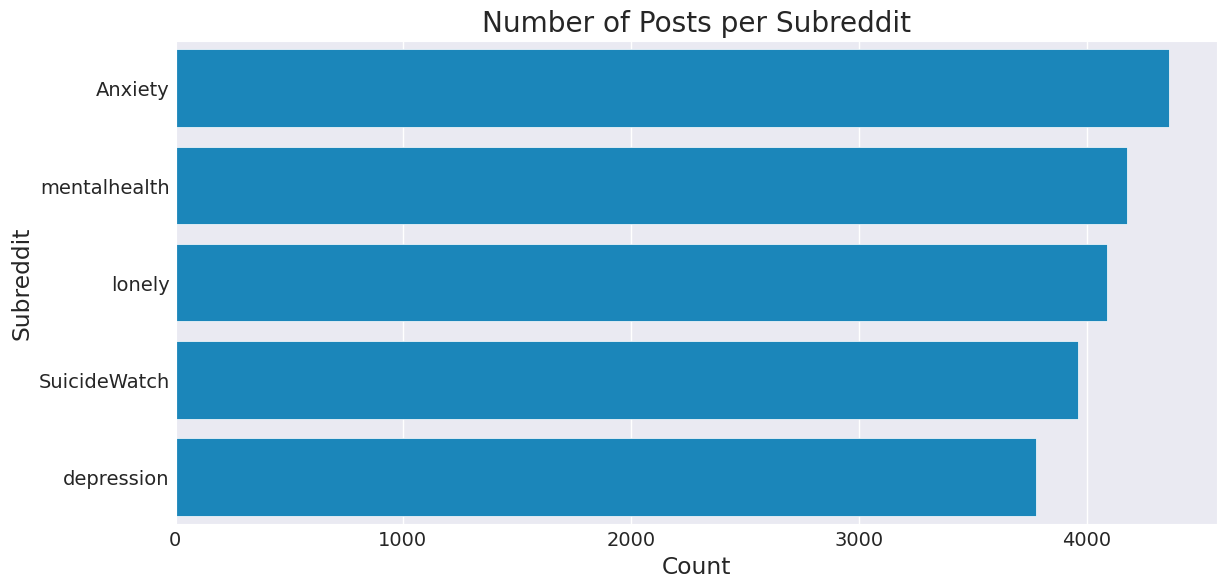

In [78]:
# Posts per subreddit
plt.figure(figsize=(12, 6))
plot = sns.countplot(y='subreddit', data=df, order=df['subreddit'].value_counts().index)
plt.title('Number of Posts per Subreddit')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.show()

fig = plot.get_figure()
fig.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Number_of_Posts_per_Subreddit.png"), dpi=300, bbox_inches='tight')

In [79]:
posts_per_month = df.groupby('year_month').size().reset_index(name='count')
posts_per_month['year_month'] = pd.to_datetime(posts_per_month['year_month'], format='%Y-%m')
posts_per_month = posts_per_month.sort_values('year_month')

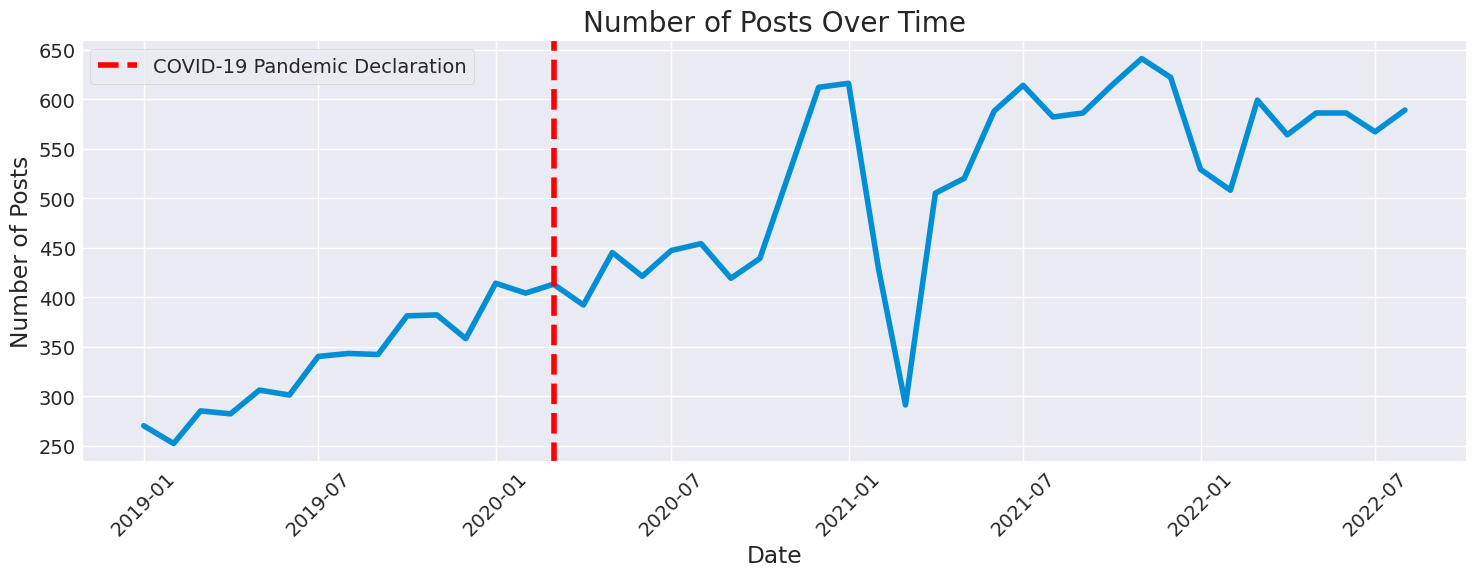

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(posts_per_month['year_month'], posts_per_month['count'])
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.axvline(x=pd.to_datetime('2020-03-01'), color='r', linestyle='--', 
            label='COVID-19 Pandemic Declaration')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Number_of_Posts_Over_Time.png"), dpi=300, bbox_inches='tight')
plt.show()

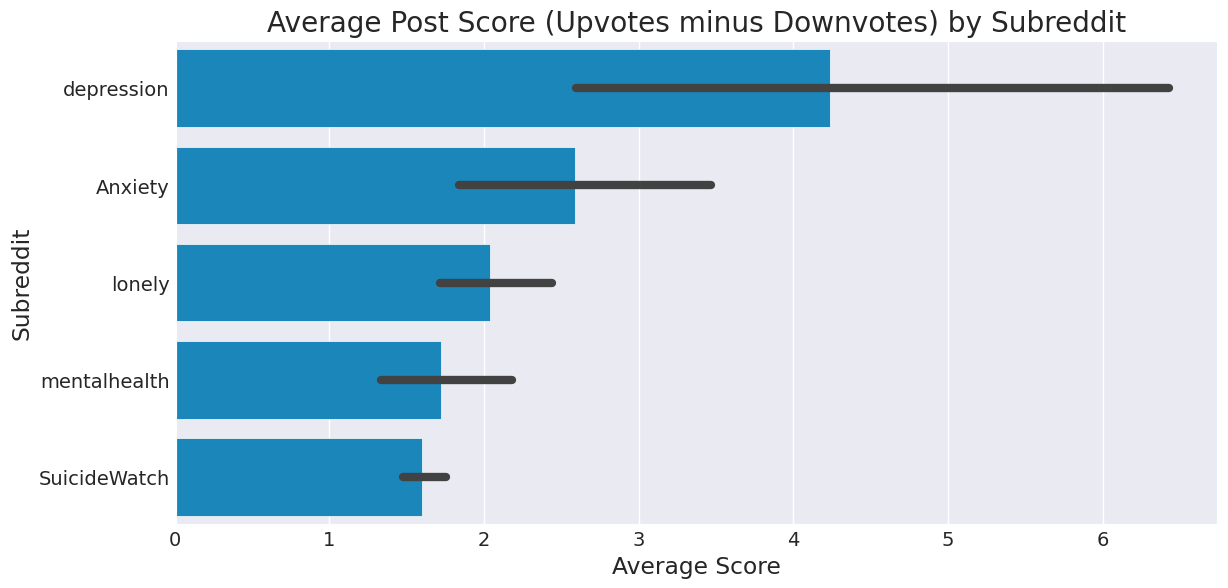

In [82]:
plt.figure(figsize=(12, 6))
sns.barplot(y='subreddit', x='score', data=df, estimator=np.mean, 
            order=df.groupby('subreddit')['score'].mean().sort_values(ascending=False).index)
plt.title('Average Post Score (Upvotes minus Downvotes) by Subreddit')
plt.xlabel('Average Score')
plt.ylabel('Subreddit')
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Average Post Score (Upvotes minus Downvotes) by Subreddit"), dpi=300, bbox_inches='tight')
plt.show()

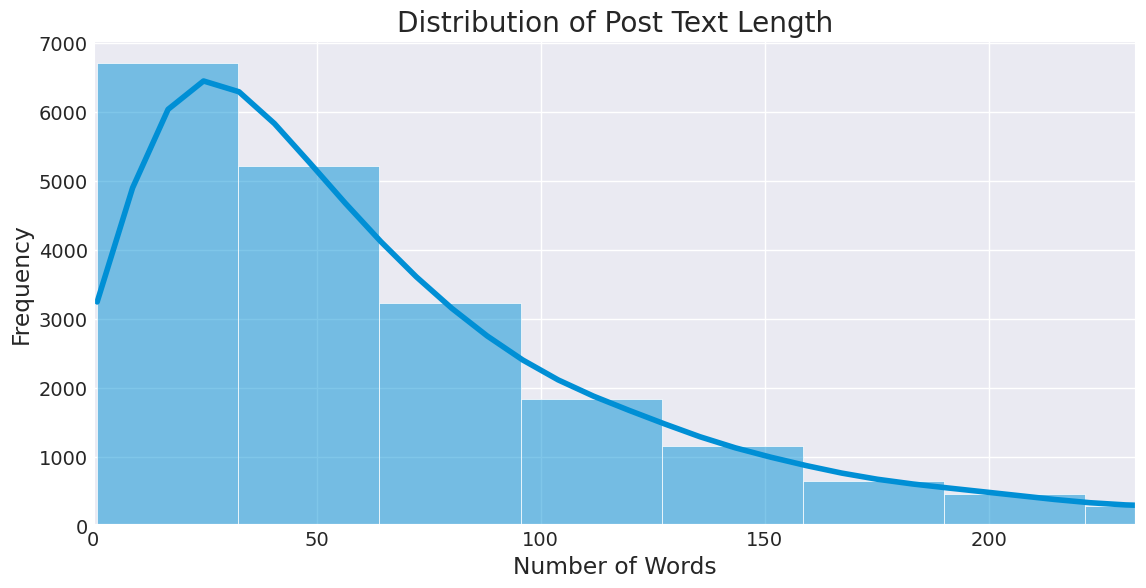

In [83]:
# Text length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['text_word_count'], bins=50, kde=True)
plt.title('Distribution of Post Text Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, df['text_word_count'].quantile(0.95)) 
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Distribution of Post Text Length.png"), dpi=300, bbox_inches='tight')
plt.show()

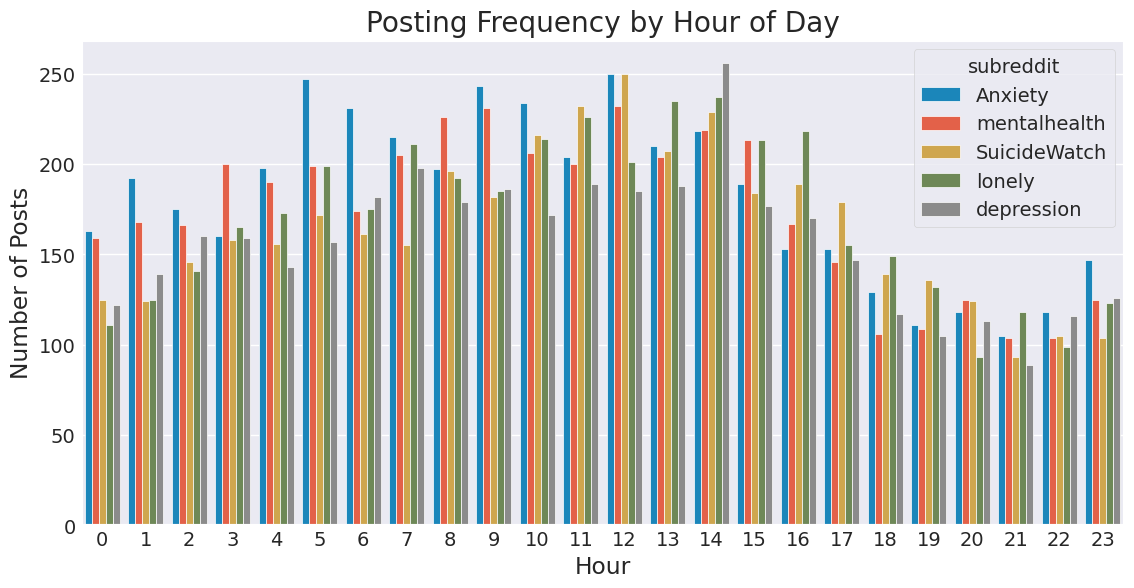

In [84]:
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', data=df, hue='subreddit')
plt.title('Posting Frequency by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Posts')
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Posting Frequency by Hour of Day.png"), dpi=300, bbox_inches='tight')
plt.show()

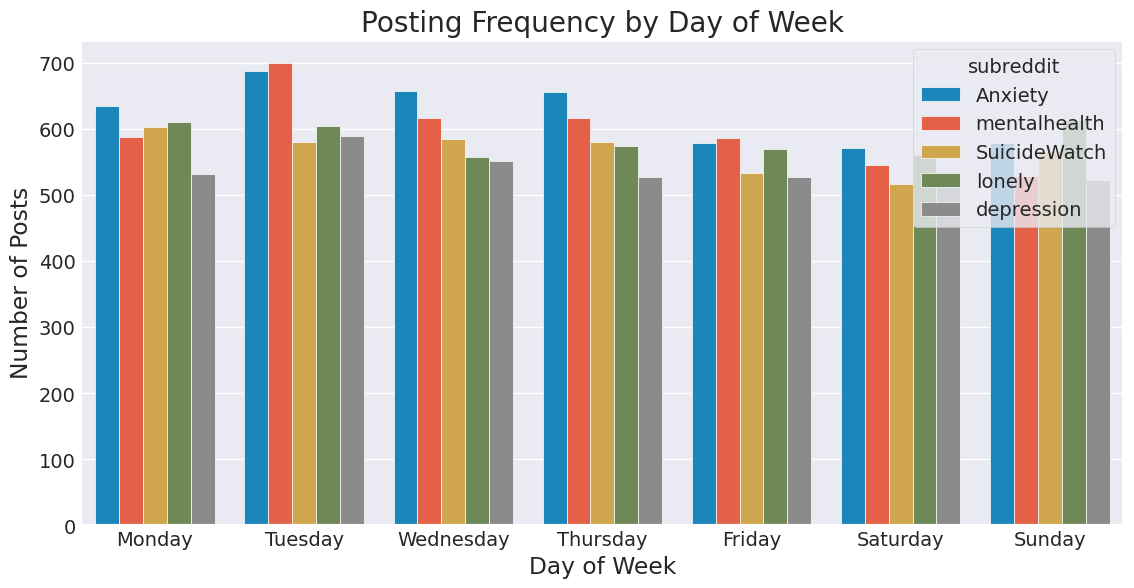

In [85]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.countplot(x='day_of_week', data=df, hue='subreddit')
plt.title('Posting Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Posts')
plt.xticks(ticks=range(7), labels=days)
plt.show()

## 3. Feature Engineering


### 3.1 Sentiment Analysis

In [86]:
sia = SentimentIntensityAnalyzer()
def get_sentiment_scores(text):
    if pd.isna(text) or text == '':
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    return sia.polarity_scores(text)

In [87]:
df['title_sentiment'] = df['title'].apply(lambda x: get_sentiment_scores(str(x))['compound'])
df['text_sentiment'] = df['text'].apply(lambda x: get_sentiment_scores(str(x))['compound'])
df['overall_sentiment'] = (df['title_sentiment'] + df['text_sentiment']) / 2

In [88]:
df['textblob_sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['textblob_subjectivity'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

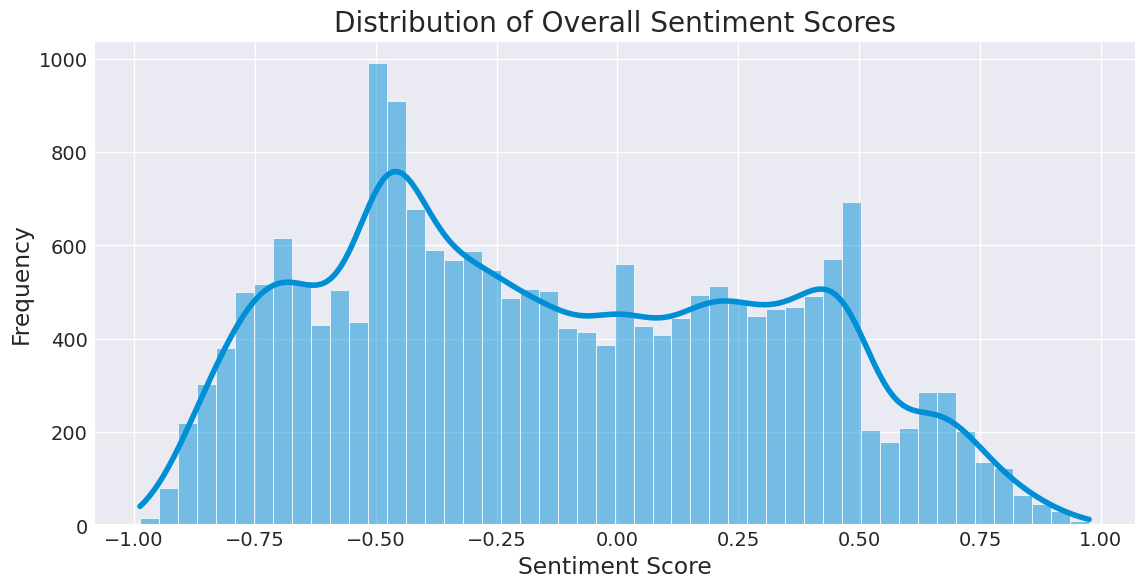

In [89]:
plt.figure(figsize=(12, 6))
sns.histplot(df['overall_sentiment'], bins=50, kde=True)
plt.title('Distribution of Overall Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Distribution of Overall Sentiment Scoresy.png"), dpi=300, bbox_inches='tight')
plt.show()

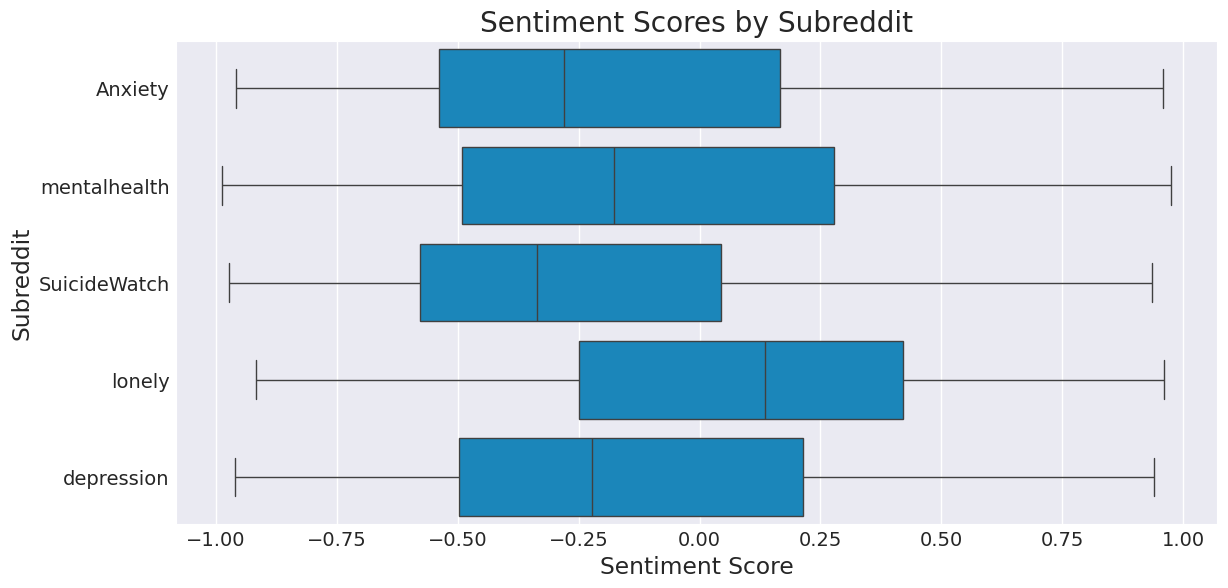

In [90]:
# Sentiment by subreddit
plt.figure(figsize=(12, 6))
sns.boxplot(y='subreddit', x='overall_sentiment', data=df)
plt.title('Sentiment Scores by Subreddit')
plt.xlabel('Sentiment Score')
plt.ylabel('Subreddit')
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Sentiment Scores by Subreddit.png"), dpi=300, bbox_inches='tight')
plt.show()

### 3.2 Word Frequency Analysis

In [113]:
def get_top_words(texts, n=20):
    words = []
    for text in texts:
        text = str(text).lower()
        words.extend([word for word in re.findall(r'\b[a-z]+\b', text) if len(word) > 2])
    
    word_counts = Counter(words)
    return word_counts.most_common(n)

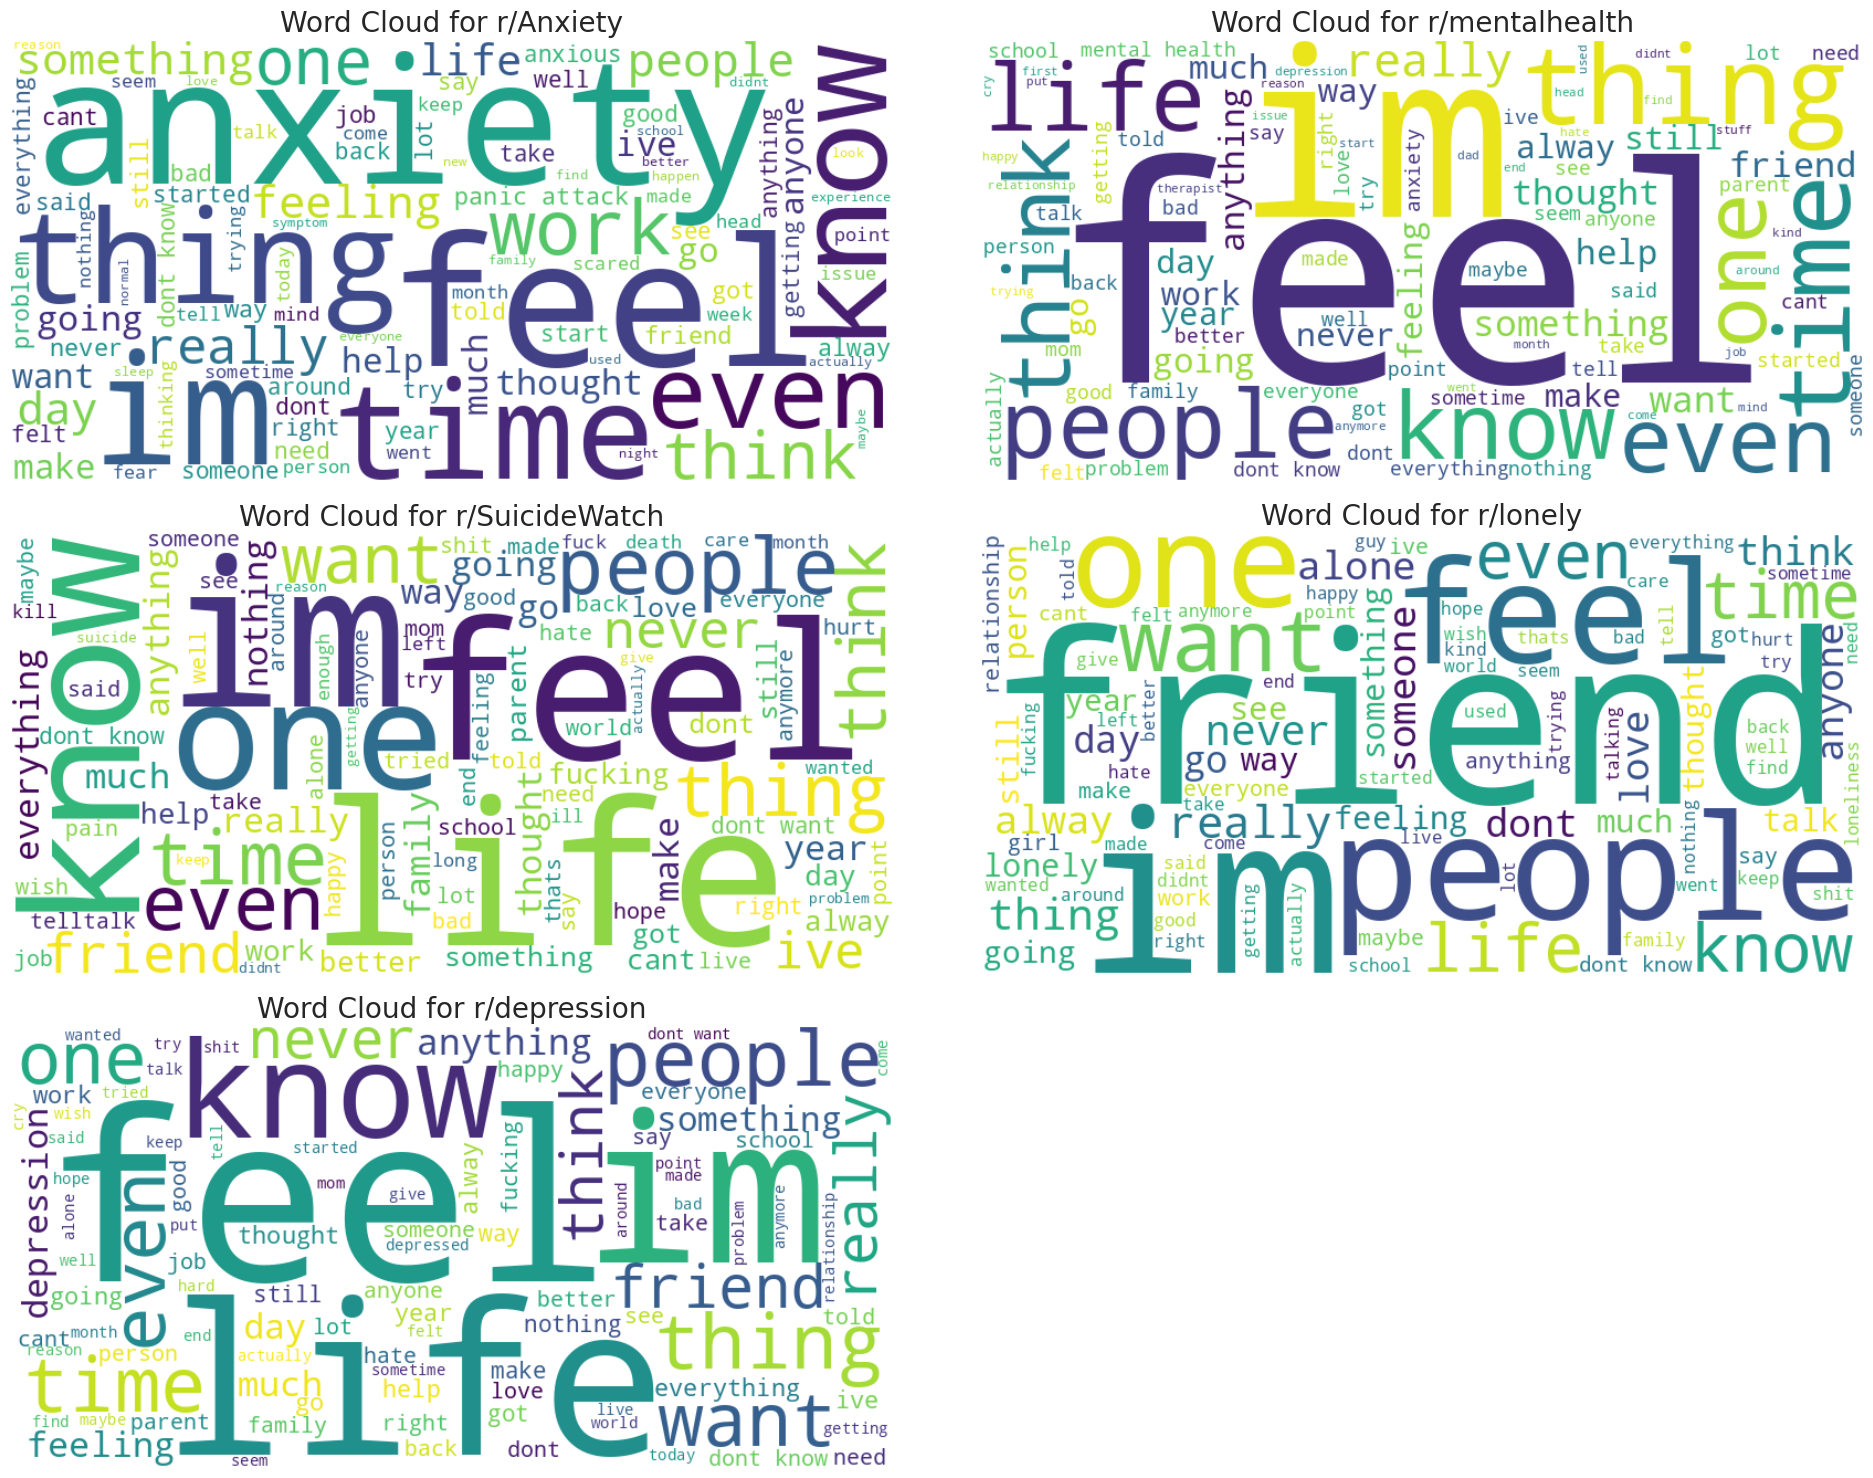

In [114]:
subreddits = df['subreddit'].unique()
plt.figure(figsize=(20, 15))

for i, subreddit in enumerate(subreddits):
    plt.subplot(3, 2, i+1)

    texts = df[df['subreddit'] == subreddit]['text'].values
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         max_words=100, contour_width=3, contour_color='steelblue').generate(' '.join(map(str, texts)))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for r/{subreddit}')
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Word Cloud for Each Subreddit.png"), dpi=300, bbox_inches='tight')
plt.show()

### TF-IDF Analysis

In [115]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.7)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'].astype(str))

In [116]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [117]:
def get_top_tfidf_words(tfidf_matrix, feature_names, subreddit_indices, n=10):
    subreddit_tfidf = tfidf_matrix[subreddit_indices].mean(axis=0)

    subreddit_tfidf = np.asarray(subreddit_tfidf).flatten()
    top_indices = subreddit_tfidf.argsort()[-n:][::-1]

    top_words = [(feature_names[i], subreddit_tfidf[i]) for i in top_indices]
    
    return top_words


Top distinctive words for r/Anxiety:
anxiety: 0.0935
like: 0.0547
feel: 0.0535
im: 0.0520
get: 0.0431
know: 0.0361
anxious: 0.0352
really: 0.0344
time: 0.0340
day: 0.0333


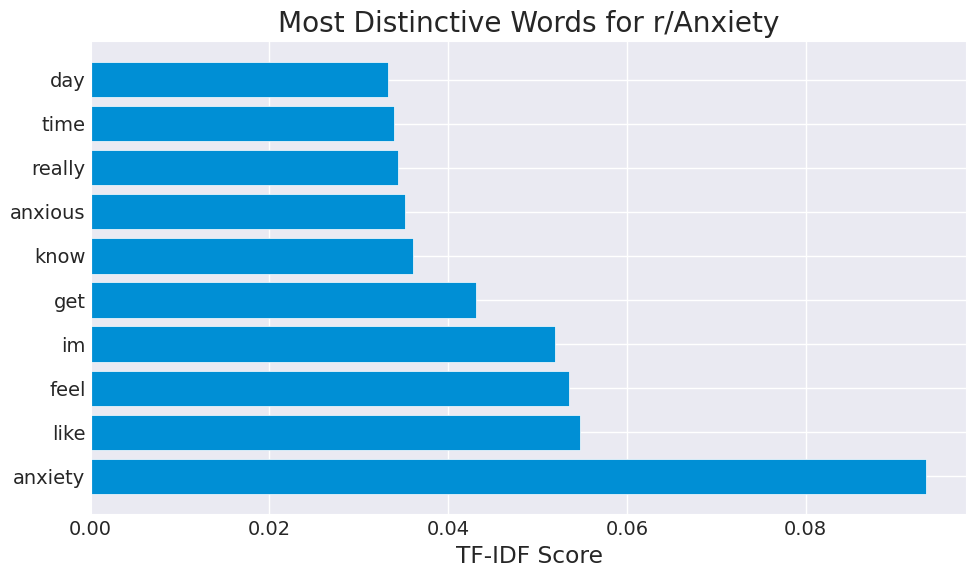


Top distinctive words for r/mentalhealth:
im: 0.0626
like: 0.0616
feel: 0.0598
know: 0.0461
dont: 0.0420
get: 0.0403
time: 0.0381
want: 0.0377
really: 0.0373
thing: 0.0355


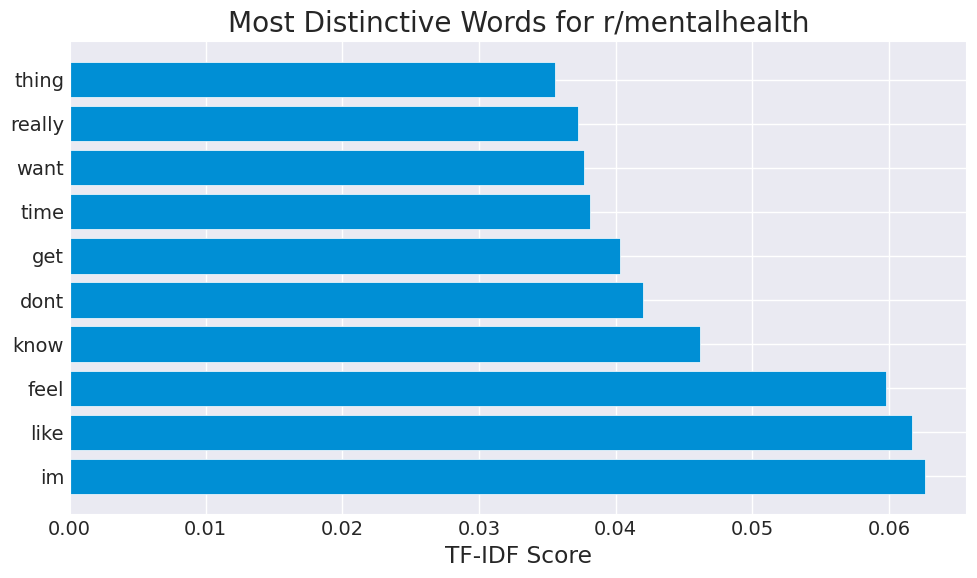


Top distinctive words for r/SuicideWatch:
im: 0.0757
want: 0.0587
life: 0.0516
dont: 0.0508
like: 0.0437
feel: 0.0425
know: 0.0397
get: 0.0326
die: 0.0315
even: 0.0315


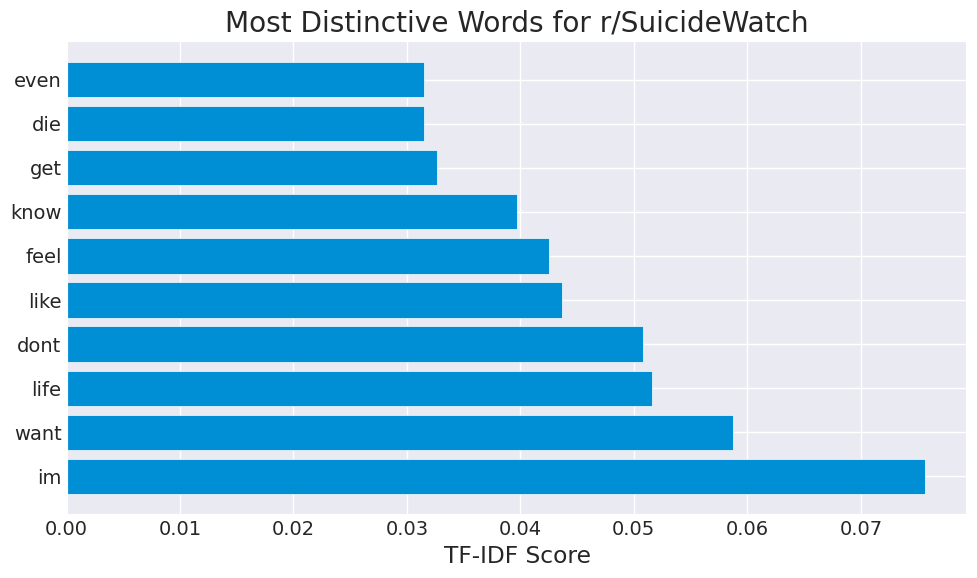


Top distinctive words for r/lonely:
friend: 0.0688
im: 0.0575
feel: 0.0500
like: 0.0500
people: 0.0494
talk: 0.0466
lonely: 0.0465
someone: 0.0439
want: 0.0414
alone: 0.0383


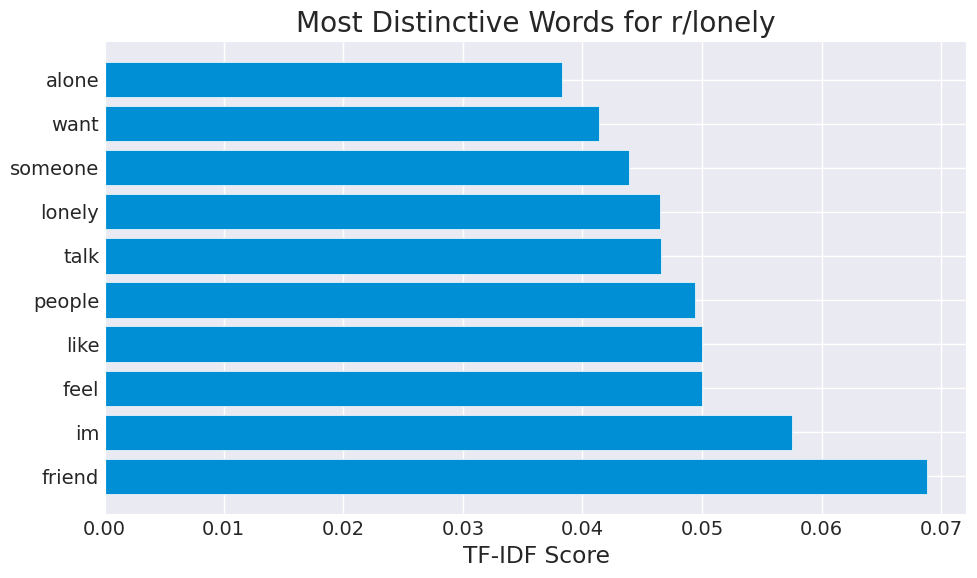


Top distinctive words for r/depression:
im: 0.0655
feel: 0.0647
like: 0.0578
dont: 0.0481
want: 0.0465
life: 0.0456
know: 0.0428
get: 0.0379
depression: 0.0355
time: 0.0352


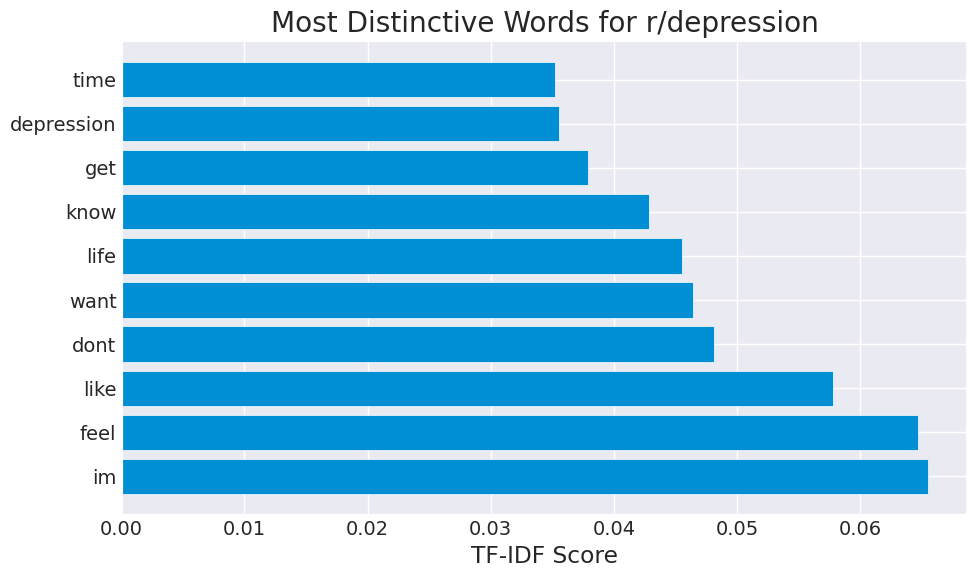

In [121]:
for subreddit in subreddits:
    subreddit_indices = df[df['subreddit'] == subreddit].index
    top_words = get_top_tfidf_words(tfidf_matrix, tfidf_feature_names, subreddit_indices)
    
    print(f"\nTop distinctive words for r/{subreddit}:")
    for word, score in top_words:
        print(f"{word}: {score:.4f}")

    plt.figure(figsize=(10, 6))
    words, scores = zip(*top_words)
    plt.barh(range(len(words)), scores, align='center')
    plt.yticks(range(len(words)), words)
    plt.xlabel('TF-IDF Score')
    plt.title(f'Most Distinctive Words for r/{subreddit}')
    plt.tight_layout()
    plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, f"Top distinctive words for subreddit: {subreddit}.png"), dpi=300, bbox_inches='tight')
    plt.show()

In [122]:
df['distress_score'] = (
    df['negative_emotion'] + 
    df['sadness'] + 
    df['fear'] + 
    df['death'] + 
    df['suffering'] + 
    df['pain'] +
    df['shame'] +
    df['violence'] - 
    df['positive_emotion'] - 
    df['love'] - 
    df['optimism'] -
    df['overall_sentiment']
)

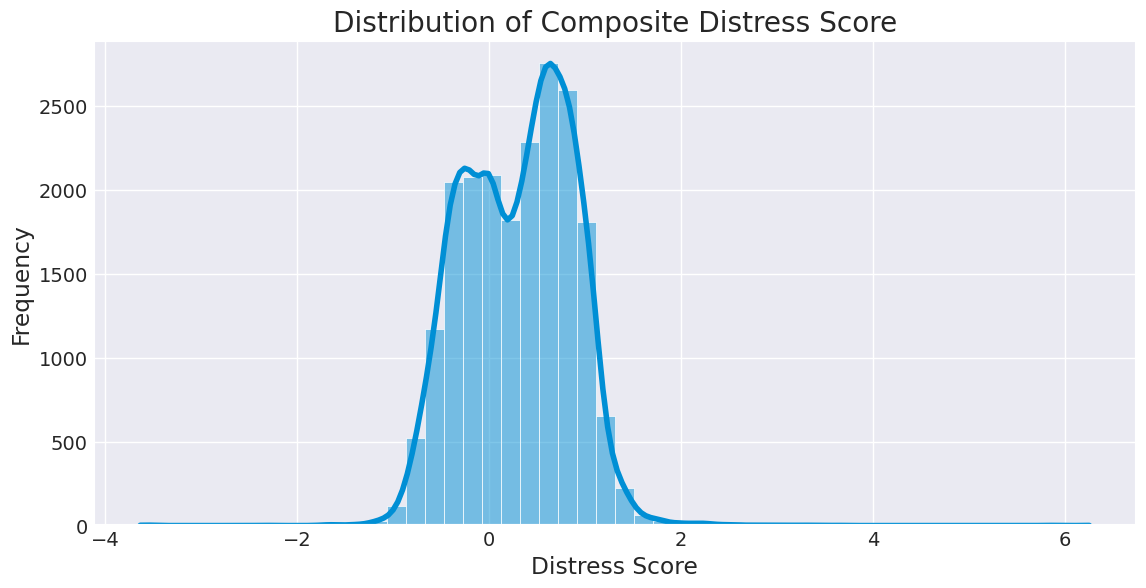

In [123]:
plt.figure(figsize=(12, 6))
sns.histplot(df['distress_score'], bins=50, kde=True)
plt.title('Distribution of Composite Distress Score')
plt.xlabel('Distress Score')
plt.ylabel('Frequency')
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Distribution of Composite Distress Score.png"), dpi=300, bbox_inches='tight')
plt.show()

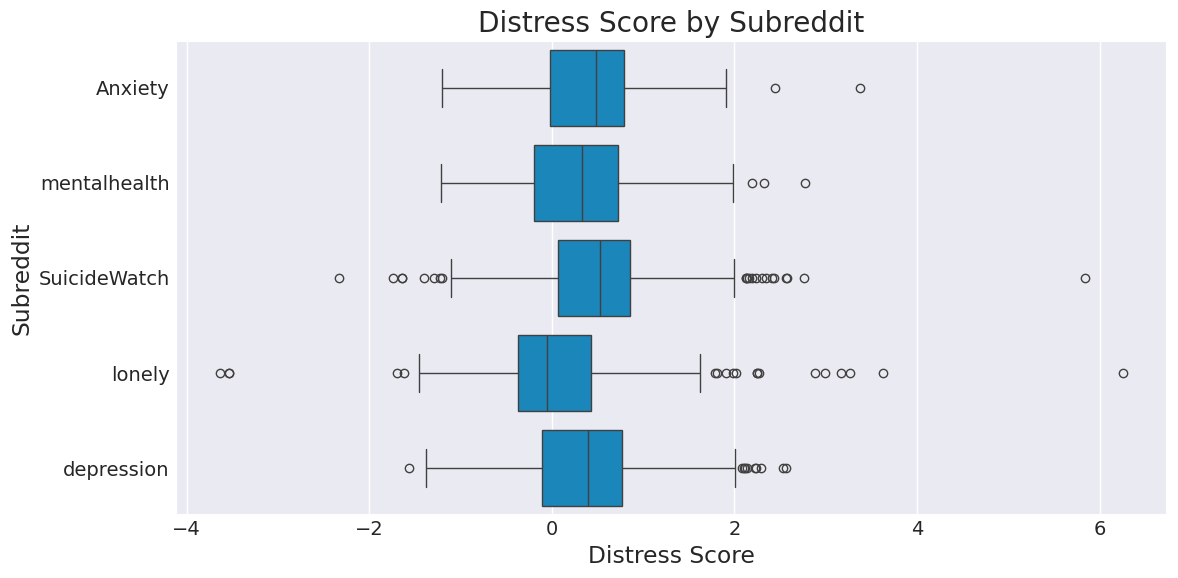

In [124]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='subreddit', x='distress_score', data=df)
plt.title('Distress Score by Subreddit')
plt.xlabel('Distress Score')
plt.ylabel('Subreddit')
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), PLOT_DIRECTORY, "Distress Score by Subreddit.png"), dpi=300, bbox_inches='tight')
plt.show()

## Saving the Dataset

In [241]:
OUTPUT_PATH = os.path.join(os.getcwd(), "data", "RHMD_Engineered.csv")
df.to_csv(OUTPUT_PATH, index=False)